In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [57]:
train2=pd.read_csv('train_v2.csv')
wkd=pd.read_csv('wkd_v1 (1).csv')
test2=pd.read_csv('test_v2_day.csv')
test2_periods=pd.read_csv('test_v2_periods.csv')

In [58]:
wkd.ORIG_DT=pd.to_datetime(wkd.ORIG_DT)
wkd=wkd.rename(columns={'ORIG_DT':'date'})

In [59]:
#构建新特征 shift
'''
1.前一天是否为周末 且 当前是工作日
2.前一天为法定假日 且 当前是工作日
3.前一天为工作日调休 且 当前是工作日
4.前一天为假期调为工作日，且 当前是工作日
5.前7天中法定假日的比例
6.前14天中法定假日的比例
7.前7天中工作日调休的比例
8.前14天中工作日调休的比例
9.前7天中假期调为工作日的比例
10.前14天中假期调为工作日的比例
'''
#为了构建新特征，这里使用shift函数来实现第前n天的type
#因为数据集前14行均有部分数据的缺失，因此在构建训练集时这部分[:14]数据需要舍弃
for i in range(1,15):
    wkd[f'last_{i}']=wkd['WKD_TYP_CD'].shift(i)

wkd=wkd.iloc[14:,:].reset_index(drop=True)

wkd['last_7days']=wkd['last_1']+' '+wkd['last_2']+' '+wkd['last_3']+' '+wkd['last_4']+' '+\
wkd['last_5']+' '+wkd['last_6']+' '+wkd['last_7']

wkd['last_7days']=wkd['last_7days'].apply(lambda x:x.split(' '))

wkd['last_14days']=wkd['last_1']+' '+wkd['last_2']+' '+wkd['last_3']+' '+wkd['last_4']+' '+\
wkd['last_5']+' '+wkd['last_6']+' '+wkd['last_7']+' '+wkd['last_8']+' '+wkd['last_9']+' '+\
wkd['last_10']+' '+wkd['last_11']+' '+wkd['last_12']+' '+wkd['last_13']+' '+wkd['last_14']

wkd['last_14days']=wkd['last_14days'].apply(lambda x:x.split(' '))

In [60]:
wkd['new1']=wkd['WKD_TYP_CD'].apply(lambda x:x=='WN')&wkd['last_1'].apply(lambda x:x=='SN')
wkd['new1']=wkd['new1'].astype(int)
wkd['afterhod']=wkd['WKD_TYP_CD'].apply(lambda x:x=='WN')&wkd['last_1'].apply(lambda x:x=='NH')
wkd['afterhod']=wkd['afterhod'].astype(int)
wkd['afterwkdch']=wkd['WKD_TYP_CD'].apply(lambda x:x=='WN')&wkd['last_1'].apply(lambda x:x=='SS')
wkd['afterwkdch']=wkd['afterwkdch'].astype(int)
wkd['afterhodch']=wkd['WKD_TYP_CD'].apply(lambda x:x=='WN')&wkd['last_1'].apply(lambda x:x=='WS')
wkd['afterhodch']=wkd['afterhodch'].astype(int)
wkd['hodratio7']=wkd['last_7days'].apply(lambda x:x.count('NH')/len(x))
wkd['hodratio14']=wkd['last_14days'].apply(lambda x:x.count('NH')/len(x))
wkd['wkdchratio7']=wkd['last_7days'].apply(lambda x:x.count('SS')/len(x))
wkd['wkdchratio14']=wkd['last_14days'].apply(lambda x:x.count('SS')/len(x))
wkd['hodchratio7']=wkd['last_7days'].apply(lambda x:x.count('WS')/len(x))
wkd['hodchratio14']=wkd['last_14days'].apply(lambda x:x.count('WS')/len(x))

In [61]:
#TRAIN
pos_a=train2[train2.post_id=='A']
pos_b=train2[train2.post_id=='B'].reset_index(drop=True)

In [62]:
pos_a.date=pd.to_datetime(pos_a.date)
pos_b.date=pd.to_datetime(pos_b.date)

In [63]:
#TEST
pos_a_test=test2[test2.post_id=='A']
pos_b_test=test2[test2.post_id=='B']
pos_a_test.date=pd.to_datetime(pos_a_test.date)
pos_b_test.date=pd.to_datetime(pos_b_test.date)

In [64]:
pos_a_test=pos_a_test.set_index('date',drop=True)
pos_b_test=pos_b_test.set_index('date',drop=True)

# 评估准则

In [65]:
def mape(prediction,target):
    assert len(prediction)==len(target)
    duration=len(target)
    error_sum=0
    for i in range(duration):
        error_sum+=abs((prediction[i]-target[i])/(target[i]+1))
    return error_sum/duration
#for task 1
def plot(df):
    plt.figure(figsize=(20,15))
    plt.plot(df.index,df.amount)
    plt.show()
    

# TASK1 天粒度

In [66]:
pos_as=['A{}'.format(i) for i in range(1,14)]
train_sub={}
for ai in pos_as:
    train_sub[ai]=pos_a[pos_a.biz_type==ai].groupby('date')[['amount']].sum()
    train_sub[ai].index=pd.DatetimeIndex(train_sub[ai].index.values,freq='D')

In [67]:
pos_b_day=pos_b.groupby('date')[['amount']].sum()
pos_b_day.index=pd.DatetimeIndex(pos_b_day.index.values,freq='D')

In [68]:
def normalization(df,col):
    max_=max(df[col].unique())
    min_=min(df[col].unique())
    df[col]=df[col].apply(lambda x:(x-min_)/(max_-min_))

def feature_construct(time_series,train=True): #time_series include the date(index) and amount
    X=pd.DataFrame()
    if train:
        X['amount']=time_series.amount
    X['date']=time_series.index
    X['year']=time_series.index.year
    X['month']=time_series.index.month
    X['day']=time_series.index.day

    X=pd.merge(X,wkd,on='date',how='left')
    for i in ['WN','SN','NH','SS','WS']:
        X[i]=X['WKD_TYP_CD'].apply(lambda x:x==i).astype(int)
    
    if train:
        X=X.iloc[14:,:].reset_index(drop=True)
    #新冠肺炎
    X['xg']=0
    for i in range(X.shape[0]):
        if X.year[i]==2020 and X.month[i] in (1,2,3):
                X['xg'][i]=1
    
    
    if train:
        output=X[['amount','year','month','day','WN','SN','NH','SS','WS',\
                    'new1',
                    'afterhod',
                    'afterwkdch',
                    'afterhodch',
                    'hodratio7',
                    'hodratio14',
                    'wkdchratio7',
                    'wkdchratio14',
                    'hodchratio7',
                    'hodchratio14',
                    'xg']]
        for i in ('year','month','day'):
            normalization(output,i)
    else:
        output=X[['year','month','day','WN','SN','NH','SS','WS',\
                   'new1',
                   'afterhod',
                   'afterwkdch',
                   'afterhodch',
                    'hodratio7',
                    'hodratio14',
                    'wkdchratio7',
                    'wkdchratio14',
                    'hodchratio7',
                    'hodchratio14',
                    'xg']] #test
        output['year']=output['year'].apply(lambda x:(x-2018)/(2020-2018))
        output['month']=output['month'].apply(lambda x:(x-1)/(12-1))
        output['day']=output['day'].apply(lambda x:(x-1)/(31-1))
    
    return output  

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from numpy import array
def models_train_predict(x,y,test_x):
    train_x_complete,train_y_complete=x,y
    train_x,valid_x=train_x_complete[:-30],train_x_complete[-30:]
    train_y,valid_y=train_y_complete[:-30],train_y_complete[-30:]
    
    min_valid_error=100
    best_model=None
    preds=[]
    model1=RandomForestRegressor(n_estimators=1000,
                         criterion='mae',
                         #max_depth=10
                        )
    model2=GradientBoostingRegressor(n_estimators=300,criterion='mae')
    model3=XGBRegressor(learning_rate=0.1,
                n_estimators=400,
                 objective='reg:squarederror',
                booster='gblinear')
    models=[model1,model2,model3]
    
    for model in models:
        model.fit(train_x,train_y)
        pred=model.predict(valid_x)
        preds.append(pred)
        valid_error=mape(pred.tolist(),valid_y.tolist())
        if valid_error<min_valid_error:
            min_valid_error=valid_error
            best_model=model
    
    #compare the performance between model average and best model
    avg_preds=model_avg(preds[0],preds[1],preds[2])
    avg_preds_error=mape(avg_preds.tolist(),valid_y.tolist())
    if avg_preds_error<min_valid_error:
        final_preds=[]
        for model in models:
            model.fit(train_x_complete,train_y_complete)
            pred=model.predict(test_x)
            final_preds.append(pred)
        return model_avg(final_preds[0],final_preds[1],final_preds[2])
        
    
    best_model.fit(train_x_complete,train_y_complete)
    prediction=best_model.predict(test_x)
    return array(prediction)


def model_avg(pred1,pred2,pred3):
    pred1_adj=[i if i>=0 else 0 for i in pred1.tolist()]
    pred2_adj=[i if i>=0 else 0 for i in pred2.tolist()]
    pred3_adj=[i if i>=0 else 0 for i in pred3.tolist()]
    pred_avg=[]
    for i in range(len(pred1_adj)):
        pred_avg.append((pred1_adj[i]+pred2_adj[i]+pred3_adj[i])/3)
    return array(pred_avg)

def predict_a(type_a):
    sub_a=train_sub[type_a]
    sub_a_train=feature_construct(sub_a,train=True)
    sub_a_test=feature_construct(pos_a_test,train=False)

    sub_a_train_y,sub_a_train_x=sub_a_train.iloc[:,0],sub_a_train.iloc[:,1:]
    
    prediction=models_train_predict(sub_a_train_x,sub_a_train_y,sub_a_test)
    prediction_adj=[i if i>=0 else 0 for i in prediction.tolist()]
    return array(prediction_adj)

#same story for b(write again just for clearity)
def predict_b():
    b_train=feature_construct(pos_b_day,train=True)
    b_test=feature_construct(pos_b_test,train=False)

    b_train_y,b_train_x=b_train.iloc[:,0],b_train.iloc[:,1:]
    
    prediction=models_train_predict(b_train_x,b_train_y,b_test)
    prediction_adj=[i if i>=0 else 0 for i in prediction.tolist()]
    return array(prediction_adj)

# 传统时间序列方法建模

In [17]:
#acf and pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [18]:
ARIMA
use classical time-series model:ARIMA
from statsmodels.tsa.arima_model import ARIMA
#parameter order=(p,d,q)
#where p: periods taken for autoregressive model
#      d: Integrated order, differnce
#      q: periods in moving average model
def arima_forecast(train_set,valid_set,d,p,q):
    model_arima=ARIMA(train_set,order=(d,p,q))
    model_arima_fit=model_arima.fit()
    
    print(model_arima_fit.aic) #check performance
    predictions=model_arima_fit.forecast(steps=31)[0]
    plt.plot(valid_set.tolist(),color='red')
    plt.plot(predictions,color='blue')

In [19]:
#position A1 as example
train_a1,valid_a1=train_valid_split(res_sub['A1'])

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_a1.tolist(),lags=30,ax=axes[0])
plot_pacf(train_a1.tolist(),lags=30,ax=axes[1])

In [20]:
arima_forecast(train_a1,valid_a1,15,1,3)

# 深度学习方法

In [ ]:
feature
import numpy as np
def split_sequence(sequence,n_steps):
    X,y=list(),list()
    for i in range(len(sequence)):
        end_ix=i+n_steps
        if end_ix>len(sequence)-1:
            break
        
        seq_x,seq_y=sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)


#take a1 as an example
a1_list=res_sub['A1']['amount'].tolist()
n_steps=60
X,y=split_sequence(sequence=a1_list,n_steps=n_steps)

In [ ]:
train/valid split
X=X.reshape(X.shape[0],1,X.shape[1])
X_train,y_train=X[:-31],y[:-31]
X_valid,y_valid=X[-31:],y[-31:]

In [ ]:
vanilla lstm
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1,n_steps)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


model.summary()

In [ ]:
checkpoint = ModelCheckpoint(filepath='lstm.ckpt',monitor='val_loss',mode='auto',save_best_only='True')
model.fit(X_train,y_train,epochs=100,verbose=1,validation_split=0.1,callbacks=[checkpoint])

In [ ]:
from tensorflow.keras.models import load_model
lstm_star=load_model('lstm.ckpt')

In [ ]:
prediction_lstm=lstm_star.predict(X_valid)
plt.plot([i for i in range(31)],prediction_lstm,color='blue')
plt.plot([i for i in range(31)],y_valid,color='red')
plt.show()

# 机器学习方法

In [69]:
#position A1 as example
a1=train_sub['A1']
a1_featured=feature_construct(a1)
train_a1_featured,valid_a1_featured=a1_featured[:-30],a1_featured[-30:]

In [70]:
train_a1_x,valid_a1_x=train_a1_featured.iloc[:,1:],valid_a1_featured.iloc[:,1:]
train_a1_y,valid_a1_y=train_a1_featured.iloc[:,0],valid_a1_featured.iloc[:,0]

In [16]:
#random forest
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=1000,
                         criterion='mae',
                         #max_depth=10
                        )
rf.fit(train_a1_x,train_a1_y)
rf_pred=rf.predict(valid_a1_x)

In [17]:
mape(prediction=rf_pred.tolist(),target=valid_a1_y.tolist())

0.23184540393131156

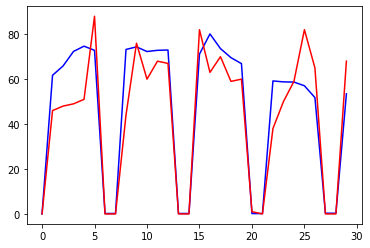

In [18]:
plt.plot([i for i in range(30)],rf_pred,color='blue')
plt.plot([i for i in range(30)],valid_a1_y,color='red')
plt.show()

In [19]:
#gbdt
from sklearn.ensemble import GradientBoostingRegressor
gbdt=GradientBoostingRegressor(n_estimators=350,criterion='mae')
gbdt.fit(train_a1_x,train_a1_y)
gbdt_pred=gbdt.predict(valid_a1_x)

In [601]:
mape(prediction=gbdt_pred.tolist(),target=valid_a1_y.tolist())

0.08484369175454237

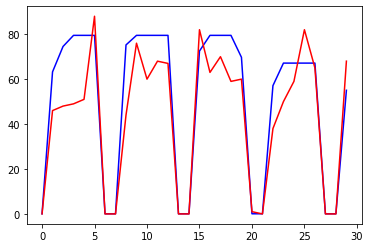

In [20]:
plt.plot([i for i in range(30)],gbdt_pred,color='blue')
plt.plot([i for i in range(30)],valid_a1_y,color='red')
plt.show()

In [71]:
#xgboost
from xgboost import XGBRegressor

In [127]:
xgb=XGBRegressor(learning_rate=0.1,
                n_estimators=10,
                 objective='reg:squarederror',
                booster='dart')

In [128]:
xgb.fit(train_a1_x,train_a1_y,eval_metric='mae')
xgb_pred=xgb.predict(valid_a1_x)

In [129]:
xgb_pred_adj=[i if i>=0 else 0 for i in xgb_pred.tolist()]

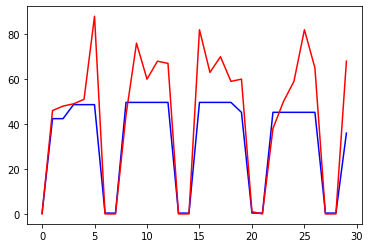

In [130]:
plt.plot([i for i in range(30)],xgb_pred_adj,color='blue')
plt.plot([i for i in range(30)],valid_a1_y,color='red')
plt.show()

In [131]:
mape(prediction=xgb_pred_adj,target=valid_a1_y.tolist())

0.2657992097959018

In [27]:
#avg of 3 models
def model_avg(pred1,pred2,pred3):
    pred1_adj=[i if i>=0 else 0 for i in pred1.tolist()]
    pred2_adj=[i if i>=0 else 0 for i in pred2.tolist()]
    pred3_adj=[i if i>=0 else 0 for i in pred3.tolist()]
    pred_avg=[]
    for i in range(len(pred1_adj)):
        pred_avg.append((pred1_adj[i]+pred2_adj[i]+pred3_adj[i])/3)
    return pred_avg
        

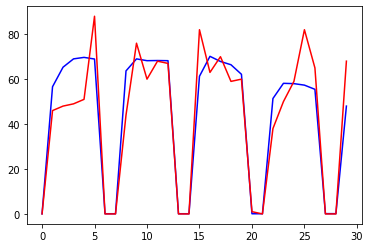

In [28]:
pred_avg=model_avg(rf_pred,gbdt_pred,xgb_pred)
plt.plot([i for i in range(30)],pred_avg,color='blue')
plt.plot([i for i in range(30)],valid_a1_y,color='red')
plt.show()

In [29]:
mape(prediction=pred_avg,target=valid_a1_y.tolist())

0.17251863300121115

In [101]:
#stacking of 3 models
# from sklearn.ensemble import StackingRegressor
# from sklearn import linear_model
# final_estimator=linear_model.LinearRegression()

In [30]:
# estimators=[('rf',rf),('gbdt',gbdt),('xgboost',xgb)]
# stackreg=StackingRegressor(estimators=estimators,
#                            cv=10,
#                            final_estimator=final_estimator)
# stackreg.fit(train_a1_x,train_a1_y)
# stack_pred=stackreg.predict(valid_a1_x)

In [31]:
# plt.plot([i for i in range(30)],stack_pred,color='blue')
# plt.plot([i for i in range(30)],valid_a1_y,color='red')
# plt.show()

In [32]:
# mape(stack_pred.tolist(),valid_a1_y.tolist())

# Task 1完整预测

In [675]:
#完整预测 a1,a2,a3....a13
test_steps=pos_a_test.shape[0]
pred_sum_a=array([0 for i in range(test_steps)],dtype=float)

for i in tqdm(pos_as):
    sub_pred=predict_a(i)
    pred_sum_a+=sub_pred
print('position A DONE!')




  0%|          | 0/13 [00:00<?, ?it/s]


  8%|▊         | 1/13 [01:35<19:06, 95.51s/it]


 15%|█▌        | 2/13 [02:48<15:24, 84.07s/it]


 23%|██▎       | 3/13 [04:11<13:57, 83.80s/it]


 31%|███       | 4/13 [06:36<14:51, 99.05s/it]


 38%|███▊      | 5/13 [07:51<12:34, 94.31s/it]


 46%|████▌     | 6/13 [09:27<11:02, 94.67s/it]


 54%|█████▍    | 7/13 [11:15<09:38, 96.50s/it]


 62%|██████▏   | 8/13 [12:35<07:52, 94.41s/it]


 69%|██████▉   | 9/13 [13:54<06:11, 92.76s/it]


 77%|███████▋  | 10/13 [15:32<04:39, 93.28s/it]


 85%|████████▍ | 11/13 [17:08<03:07, 93.51s/it]


 92%|█████████▏| 12/13 [18:42<01:33, 93.56s/it]


100%|██████████| 13/13 [20:16<00:00, 93.59s/it]




position A DONE!


In [676]:
#预测b1
pred_b=predict_b()
print('position B DONE!')

position B DONE!


In [677]:
#submit
final_prediction=[]
for i in range(test_steps):
    final_prediction.append(pred_sum_a[i])
    final_prediction.append(pred_b[i])

test2['amount']=final_prediction
test2.amount=test2.amount.apply(lambda x:round(x))

In [678]:
test2.to_csv('task1_pred2_2.txt',index=False)

# Task2

In [33]:
#train a2
pos_as=['A{}'.format(i) for i in range(1,14)]
train_sub2={}
for i in pos_as:
    train_sub2[i]=pos_a[pos_a.biz_type==i][['date','periods','amount']]

In [34]:
#train b2
pos_b_hour=pos_b[['date','periods','amount']]

In [35]:
#test2
pos_a_test2=test2_periods[test2_periods['post_id']=='A'][['date','periods']]
pos_a_test2['date']=pd.to_datetime(pos_a_test2['date'])

pos_b_test2=test2_periods[test2_periods['post_id']=='B'][['date','periods']]
pos_b_test2['date']=pd.to_datetime(pos_b_test2['date'])

In [272]:
#对于periods做聚合来看一下构建其余特征的可能性
# a1=train_sub2['A1']
# a1.groupby('periods')[['amount']].sum()

In [36]:
def feature_construct2(time_series,train=True): #time_series include the date(index) and amount
    X=pd.DataFrame()
    if train:
        X['amount']=time_series.amount
    X['date']=time_series.date
    X['year']=time_series.date.apply(lambda x:x.year)
    X['month']=time_series.date.apply(lambda x:x.month)
    X['day']=time_series.date.apply(lambda x:x.day)
    X['period']=time_series.periods
    X['morning']=0
    X['morning']=X['period'].apply(lambda x:x in [i for i in range(18,26)]).astype(int)
    X['afternoon']=0
    X['afternoon']=X['period'].apply(lambda x:x in [i for i in range(26,37)]).astype(int)

    X=pd.merge(X,wkd,on='date',how='left')
    
    for i in ['WN','SN','NH','SS','WS']:
        X[i]=X['WKD_TYP_CD'].apply(lambda x:x==i).astype(int)
    
    if train:
        X=X.iloc[48*14:,:].reset_index(drop=True)
    
    #新冠肺炎
    X['xg']=0
    for i in range(X.shape[0]):
        if X.year[i]==2020 and X.month[i] in (1,2,3):
                X['xg'][i]=1
    if train:
        output=X[['amount','year','month','day','period','morning','afternoon','WN','SN','NH','SS','WS',\
                  'new1',
                  'afterhod',
                  'afterwkdch',
                  'afterhodch',
                  'hodratio7',
                  'hodratio14',
                  'wkdchratio7',
                  'wkdchratio14',
                  'hodchratio7',
                  'hodchratio14',
                  'xg']]
        for i in ('year','month','day','period'):
            normalization(output,i)
    else:
        output=X[['year','month','day','period','morning','afternoon','WN','SN','NH','SS','WS',
                  'new1',
                  'afterhod',
                  'afterwkdch',
                  'afterhodch',
                  'hodratio7',
                  'hodratio14',
                  'wkdchratio7',
                  'wkdchratio14',
                  'hodchratio7',
                  'hodchratio14',
                  'xg']] #test
        output['year']=output['year'].apply(lambda x:(x-2018)/(2020-2018))
        output['month']=output['month'].apply(lambda x:(x-1)/(12-1))
        output['day']=output['day'].apply(lambda x:(x-1)/(31-1))
        output['period']=output['period'].apply(lambda x:(x-1)/(48-1))
    
    return output 

In [37]:
#take a1 as example
a1_2=train_sub2['A1']
a1_featured2=feature_construct2(a1_2)
train_a1_featured2,valid_a1_featured2=a1_featured2[:-30*48],a1_featured2[-30*48:]

In [38]:
train_a1_x2,valid_a1_x2=train_a1_featured2.iloc[:,1:],valid_a1_featured2.iloc[:,1:]
train_a1_y2,valid_a1_y2=train_a1_featured2.iloc[:,0],valid_a1_featured2.iloc[:,0]

In [45]:
import time

In [48]:
rf2=RandomForestRegressor(n_estimators=100,
                         criterion='mae',
                         max_depth=5,
                         min_samples_split=30,
                         min_samples_leaf=5,
                        max_features='sqrt')
start=time.time()
rf2.fit(train_a1_x2,train_a1_y2)
print(f'training use {time.time()-start} seconds')
rf_pred=rf2.predict(valid_a1_x2)

training use 1182.4787480831146 seconds


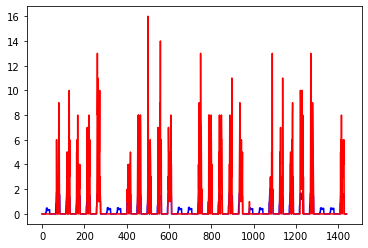

In [49]:
plt.plot([i for i in range(30*48)],rf_pred,color='blue')
plt.plot([i for i in range(30*48)],valid_a1_y2,color='red')
plt.show()

In [51]:
mape(prediction=rf_pred.tolist(),target=valid_a1_y2.tolist())

0.1966457900816051

In [52]:
model1=XGBRegressor(learning_rate=0.1,
                n_estimators=300,
                 objective='reg:squarederror')
model1.fit(train_a1_x2,train_a1_y2)
pred_xgb_a1=model1.predict(valid_a1_x2)
pred_xgb_a1_adj=[i if i>=0 else 0 for i in pred_xgb_a1.tolist()]

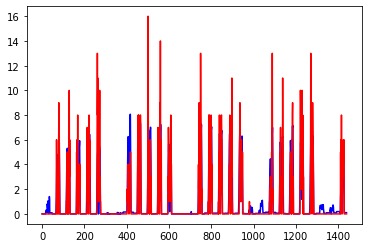

In [53]:
plt.plot([i for i in range(30*48)],pred_xgb_a1_adj,color='blue')
plt.plot([i for i in range(30*48)],valid_a1_y2,color='red')
plt.show()

In [54]:
mape(prediction=pred_xgb_a1_adj,target=valid_a1_y2.tolist())

0.23385117194584407

# Task 2完整预测

In [671]:
#predict for a1,a2...a13
test_steps2=pos_a_test2.shape[0]
pred_a_sum2=array([0 for i in range(test_steps2)],dtype=float)

for i in tqdm(pos_as):
    sub_a2=train_sub2[i]
    sub_a2_train=feature_construct2(sub_a2)
    a2_test=feature_construct2(pos_a_test2,train=False)
    
    sub_a2_train_x,sub_a2_train_y=sub_a2_train.iloc[:,1:],sub_a2_train.iloc[:,0]
    model=XGBRegressor(learning_rate=0.1,
                n_estimators=200,
                 objective='reg:squarederror')
    model.fit(sub_a2_train_x,sub_a2_train_y)
    pred=model.predict(a2_test)
    pred_adj=[i if i>=0 else 0 for i in pred.tolist()]
    pred_adj=array(pred_adj)
    pred_a_sum2+=pred_adj
print('Done')  




  0%|          | 0/13 [00:00<?, ?it/s]


  8%|▊         | 1/13 [00:08<01:38,  8.19s/it]


 15%|█▌        | 2/13 [00:17<01:34,  8.59s/it]


 23%|██▎       | 3/13 [00:26<01:27,  8.77s/it]


 31%|███       | 4/13 [00:34<01:18,  8.67s/it]


 38%|███▊      | 5/13 [00:43<01:09,  8.73s/it]


 46%|████▌     | 6/13 [00:52<01:01,  8.72s/it]


 54%|█████▍    | 7/13 [01:00<00:51,  8.63s/it]


 62%|██████▏   | 8/13 [01:08<00:42,  8.56s/it]


 69%|██████▉   | 9/13 [01:16<00:33,  8.49s/it]


 77%|███████▋  | 10/13 [01:24<00:25,  8.43s/it]


 85%|████████▍ | 11/13 [01:32<00:16,  8.40s/it]


 92%|█████████▏| 12/13 [01:40<00:08,  8.41s/it]


100%|██████████| 13/13 [01:52<00:00,  8.62s/it]




Done


In [672]:
#predict for b
train_b2=feature_construct2(pos_b_hour)
test_b2=feature_construct2(pos_b_test2,train=False)
train_b2_y,train_b2_x=train_b2.iloc[:,0],train_b2.iloc[:,1:]

model2=XGBRegressor(learning_rate=0.1,
                  n_estimators=200,
                  objective='reg:squarederror')
    
model2.fit(train_b2_x,train_b2_y)
pred_b2=model2.predict(test_b2)
pred_b2_adj=[i if i>=0 else 0 for i in pred_b2.tolist()]

In [673]:
#submit
final_prediction2=[]
pred_a2=pred_a_sum2.tolist()
pred_b2=pred_b2_adj
#dec has 31 days
for i in range(31):
    final_prediction2+=pred_a2[i*48:(i+1)*48]
    final_prediction2+=pred_b2[i*48:(i+1)*48]

test2_periods['amount']=final_prediction2
test2_periods.amount=test2_periods.amount.apply(lambda x:round(x))

test2_periods.to_csv('task2_pred2.txt',index=False)